In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
import numpy as np
from numpy.linalg import qr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg import HeisenbergModel, get_graph, get_positions, get_prob0
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    thermal_relaxation_error,
    depolarizing_error,
    pauli_error,
)
from qiskit import transpile
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import BackendSamplerV2
from qiskit.quantum_info import (
    Statevector,
    state_fidelity,
    DensityMatrix,
    random_statevector,
    average_gate_fidelity,
    process_fidelity,
    SuperOp,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import json

In [4]:
import warnings

warnings.filterwarnings("ignore")

## $n_{\text{step}}$ の決定

2 量子ビットゲートによる fidelity 減少レートにより導出する。具体的には以下のような手順で求める。

1. 回路で生じるエラーは、(SPAM エラーを除けば) 2 量子ビットゲートが支配的であると仮定し、2 量子ビットゲートの個数を数える。実行時はコンパイルされるので、これより少なくなることに注意 (あくまでもここで求めているのは上限)

(下図は $n=8, n_{\text{step}}=1$ の場合)
![hoge](./img/counting_2qubit_gates.jpg)

**GHZ 部分** :

$\text{GHZ}$ と $\text{GHZ}^{\dagger}$ の左右 2 個あるので、
\begin{align*}
\left( \frac{n}{2}-1\right) \times2=n-2
\end{align*}

**$e^{-iHt}$ 部分** :

2 次のトロッターの場合は $H_{\text{odd}}$ が $n_{\text{step}}+1$ 個ある。各 $H_{\text{odd}}=H_{1,2}+H_{3,4}+\cdots H_{n-3, n-2}$ の項数は、 $\frac{n}{2}-1$.

2 次のトロッターの場合は $H_{\text{even}}$ が $n_{\text{step}}$ 個ある。各 $H_{\text{even}}=H_{0,1}+H_{2,3}+\cdots H_{n-2, n-1}$ の項数は、 $\frac{n}{2}.$

各 $e^{-iH_{i, i+1}t}$ には、2 個の CNOT が含まれるので、CNOT の個数は
\begin{align*}
2\times\left\{\underbrace{\left(\frac{n}{2}-1\right)(n_{\text{step}}+1)}_{H_{\text{odd}}}+\underbrace{\frac{n}{2}\cdot n_{\text{step}}}_{H_{\text{even}}}\right\} = 2n n_{\text{step}} + n -2n_{\text{step}}-2
\end{align*}

GHZ 部分と $e^{-iHt}$ 部分を合わせて、回路全体の CNOT の個数は
\begin{align*}
(n-2)+2n n_{\text{step}} + n -2n_{\text{step}}-2 = 2\left\{(n-1)(n_{\text{step}}+1)-1\right\}
\end{align*}
以下では、この回路をコンパイルした後の CZ ゲートも同程度の個数であると仮定する。


2. 次に、次に、2 量子ビットゲートのエラー率を求める。これは [IBM の公式サイト](https://quantum.ibm.com/)に CZ の中央値が掲載されており、2025 年 1 月 15 日現在、およそ $\epsilon=0.22$% である。

3. 以上より、 $n_{\text{step}}$ step の回路全体の fidelity は
\begin{align*}
(1-\epsilon)^{2\left\{(n-1)(n_{\text{step}})-1\right\}}.
\end{align*}

上の式より、閾値を例えば fidelity 0.80 以上と決めれば、適切な $n_{\text{step}}$ が求められる。

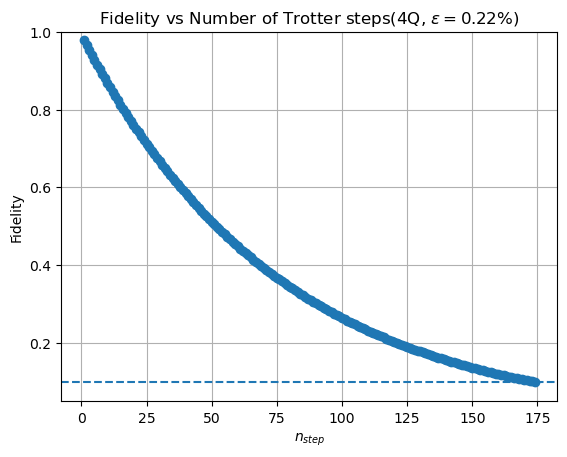

threshold: 0.1000
n_step just before reaching the threshold(0.10): 173
We use this max_n_step=173 for the simulation.


In [5]:
n_qubits = 4
epsilon = 0.0022

if n_qubits == 4:
    threshold = 0.1
else:
    threshold = 0.01
min_n_step_to_check = (
    5  # 最低限この回数だけは確認する. グラフの見栄えを綺麗にするために設定
)
fidelities = []
n_step_counter = 1
flag_threshold = False  # 閾値に達したかどうかのフラグ

while True:
    fidelity = (1 - epsilon) ** (2 * ((n_qubits - 1) * (n_step_counter + 1) - 1))
    fidelities.append(fidelity)
    # print(f"n_step: {n_step}, fidelity: {fidelity}")

    # 閾値に達した場合、その直前の n_counter を n_step とする
    if fidelity < threshold and flag_threshold == False:
        max_n_step = n_step_counter - 1
        flag_threshold = True

    # 閾値に達したとしても、min_n_step_to_check に達していない場合は、そのまま続行
    if fidelity < threshold and n_step_counter >= min_n_step_to_check:
        break
    n_step_counter += 1

plt.plot(range(1, len(fidelities) + 1), fidelities, marker="o")
plt.xlabel(r"$n_{step}$")
plt.ylabel("Fidelity")
plt.grid()
plt.axhline(y=threshold, linestyle="dashed")
plt.ylim(min(fidelities) - 0.05, 1)
plt.title(
    rf"Fidelity vs Number of Trotter steps({n_qubits}Q, $\epsilon={epsilon * 100}$%)"
)
plt.savefig(f"results/get_param/{n_qubits}Q_fidelity_vs_nstep.pdf")
plt.show()

print(f"threshold: {threshold:.4f}")
print(f"n_step just before reaching the threshold({threshold:.2f}): {max_n_step}")
print(rf"We use this max_n_step={max_n_step} for the simulation.")

## シミュレートする最大時間 $t_K$ (特徴量 $K$) の決定

上のようにして求めた $n_{\text{step}}$ を使い、ランダムに複数個作ったハミルトニアンについてトロッターシミュレーションを行う。その後、複数ハミルトニアンについての平均 fidelity が閾値 xx 以上となる最大の $t$ を $t_K$ とする。

### Check graph (i.e., Heisenberg Hamiltonian)

今回用いるハイゼンベルクモデルを networkx のグラフとして表す。

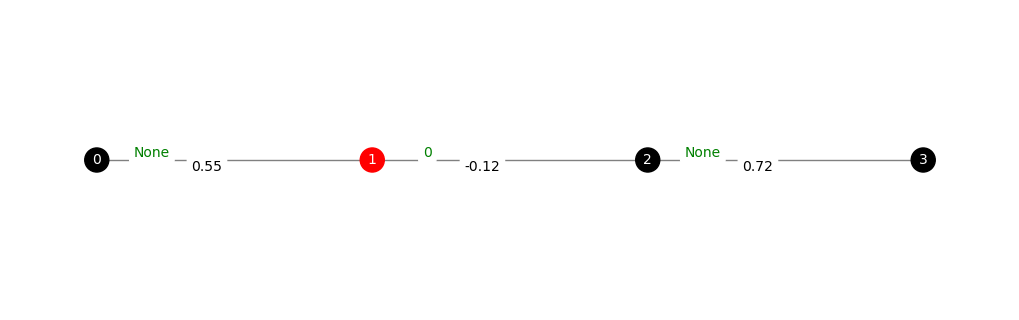

In [6]:
rng = np.random.default_rng(42)
Js = rng.uniform(-1, 1, size=n_qubits - 1)

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

上の図で、
- 丸はスピンを表し、量子回路を実行するときには量子ビットとしてマップされる
- 赤い丸は、GHZ 部分の最初にアダマールゲートが作用する量子ビットである
- エッジの緑の数字は、GHZ 部分で CNOT が作用する順番である。効率的にエンタングルメントが広がるように、アダマールゲートが作用した量子ゲートから順に CNOT をかけていく。GHZ 部分で用意したい状態は $\ket{00111100}$ (中心半分が 1) なので、CNOT が作用する量子ビットは中心の半分である。'None' はそれ以外、つまり CNOT が作用されず、0 のままであることを表す
- エッジの黒の数字は、相互作用強度 $J_{ij}$ を表す。「ランダムなハミルトニアンを作る」とは、これらの $J_{ij}$ をランダムに作ることを意味する。

### Backend の設定

In [7]:
# Option1: Use IBM Quantum backend.

# Set up the Qiskit Runtime service (this is a one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")
print(f"Using backend QPU: {backend_qpu}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>


In [8]:
# Option2: Use local AerSimulator as the backend.

# Noiseless simulator
backend_sim_noiseless = AerSimulator()
print(f"Using backend noiseless simulator: {backend_sim_noiseless}")
print()

# Noise model
noise_backend = NoiseModel.from_backend(backend_qpu)
print(noise_backend)
print()

# Noisy simulator
backend_sim_noisy = AerSimulator(noise_model=noise_backend)
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend noiseless simulator: AerSimulator('aer_simulator')

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'cz', 'x', 'id', 'sx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('reset', (0,)), ('re

実機ノイズがない状態で、Trotter 誤差を調べる

In [34]:
times = np.arange(0, 200, 5)
results = []

rng = np.random.default_rng(42)
Js = rng.uniform(-1, 1, size=n_qubits - 1)
G = get_graph(n_qubits, Js)
heisenberg = HeisenbergModel(n_qubits, G)

for t in times:
    # initial state (for state fidelity)
    state_init = Statevector.from_label("0" * n_qubits)

    # Exact simulation (Non-Trotter)
    state_exact, U_exact = heisenberg.exact_simulation(t, phase=0)
    prob0_exact = state_exact.probabilities_dict().get("0" * n_qubits, 0)
    U_exact = Operator(U_exact.toarray())

    state_after_evo_exact = state_init.evolve(U_exact)

    # Trotter simulation
    for n_step in range(1, max_n_step + 1, 50):
        print(f"t: {t:.3f}, n_step: {n_step}")
        circuit = heisenberg.get_circuit(t, n_step, phase=0)
        U_trotter = Operator.from_circuit(circuit)

        state_trotter = state_init.evolve(U_trotter)

        sta_fidelity = state_fidelity(state_exact, state_trotter)
        pro_fidelity = process_fidelity(U_exact, U_trotter)

        results.append(
            {
                "t": t,
                "n_step": n_step,
                "sta_fidelity": sta_fidelity,
                "pro_fidelity": pro_fidelity,
            }
        )

t: 0.000, n_step: 1
t: 0.000, n_step: 51
t: 0.000, n_step: 101
t: 0.000, n_step: 151
t: 5.000, n_step: 1
t: 5.000, n_step: 51
t: 5.000, n_step: 101
t: 5.000, n_step: 151
t: 10.000, n_step: 1
t: 10.000, n_step: 51
t: 10.000, n_step: 101
t: 10.000, n_step: 151
t: 15.000, n_step: 1
t: 15.000, n_step: 51
t: 15.000, n_step: 101
t: 15.000, n_step: 151
t: 20.000, n_step: 1
t: 20.000, n_step: 51
t: 20.000, n_step: 101
t: 20.000, n_step: 151
t: 25.000, n_step: 1
t: 25.000, n_step: 51
t: 25.000, n_step: 101
t: 25.000, n_step: 151
t: 30.000, n_step: 1
t: 30.000, n_step: 51
t: 30.000, n_step: 101
t: 30.000, n_step: 151
t: 35.000, n_step: 1
t: 35.000, n_step: 51
t: 35.000, n_step: 101
t: 35.000, n_step: 151
t: 40.000, n_step: 1
t: 40.000, n_step: 51
t: 40.000, n_step: 101
t: 40.000, n_step: 151
t: 45.000, n_step: 1
t: 45.000, n_step: 51
t: 45.000, n_step: 101
t: 45.000, n_step: 151
t: 50.000, n_step: 1
t: 50.000, n_step: 51
t: 50.000, n_step: 101
t: 50.000, n_step: 151
t: 55.000, n_step: 1
t: 55.00

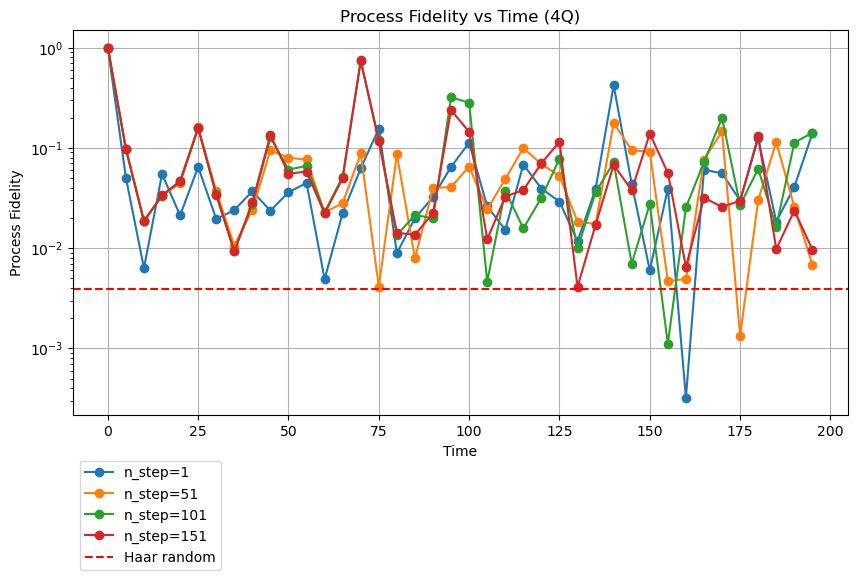

In [35]:
df = pd.DataFrame(results)

# t と n_step ごとに pro_fidelity をグループ化
df_grouped = df.groupby(["t", "n_step"]).agg({"pro_fidelity": "mean"})
df_grouped = df_grouped.reset_index()

# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped["n_step"].unique():
    df_tmp = df_grouped[df_grouped["n_step"] == n_step]
    plt.plot(df_tmp["t"], df_tmp["pro_fidelity"], label=f"n_step={n_step}", marker="o")
random_pro_fidelity = 1 / (2 ** (2 * n_qubits))
plt.axhline(y=random_pro_fidelity, color="red", linestyle="dashed", label="Haar random")
plt.xlabel("Time")
plt.ylabel("Process Fidelity")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.grid()
plt.title(f"Process Fidelity vs Time ({n_qubits}Q)")
# plt.savefig(f"results/get_param/{n_qubits}Q_fidelity_vs_time.pdf")
plt.show()

,t,n_step,sta_fidelity
0,0,1,1.000000
1,0,51,1.000000
2,0,101,1.000000
3,0,151,1.000000
4,5,1,0.778110
...,...,...,...
155,190,151,0.370340
156,195,1,0.475526
157,195,51,0.140202
158,195,101,0.307163


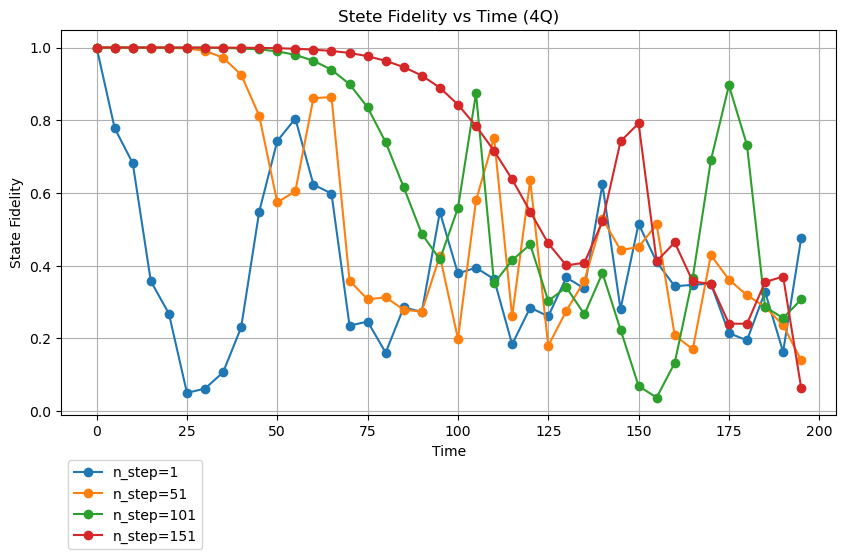

In [36]:
df = pd.DataFrame(results)
# t と n_step ごとに sta_fidelity をグループ化
df_grouped = df.groupby(["t", "n_step"]).agg({"sta_fidelity": "mean"})
df_grouped = df_grouped.reset_index()
display(df_grouped)

# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped["n_step"].unique():
    df_tmp = df_grouped[df_grouped["n_step"] == n_step]
    plt.plot(df_tmp["t"], df_tmp["sta_fidelity"], label=f"n_step={n_step}", marker="o")
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.grid()
plt.title(f"Stete Fidelity vs Time ({n_qubits}Q)")
# plt.savefig(f"results/get_param/{n_qubits}Q_fidelity_vs_time.pdf")
plt.show()